## Import library

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet_v2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Validasi pakai augmentasi proses

In [ ]:
# Data augmentation untuk training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    brightness_range=[0.95, 1.05],
    horizontal_flip=False,
    fill_mode='nearest'
)

# Data preprocessing untuk validation dan test tanpa augmentasi
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
# Generator untuk data train
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

# Generator untuk data validation
validation_generator = train_datagen.flow_from_directory(
    val_directory,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Generator untuk data test
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 592 images belonging to 4 classes.
Found 198 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


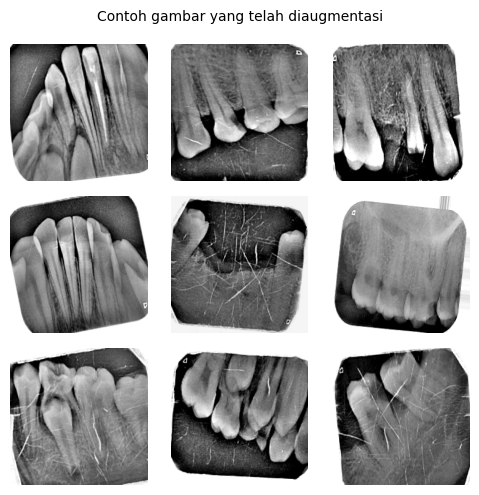

In [ ]:
# Visualisasi Data Augmentasi
augmented_images, _ = next(train_generator)
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.suptitle('Contoh gambar yang telah diaugmentasi', fontsize=10)
plt.tight_layout()
plt.show()

# Resnet101v2

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model4 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model4.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ ?                      │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 1,054,720 (4.02 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history4 = model4.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.2689 - loss: 1.6341 - val_accuracy: 0.3131 - val_loss: 1.3821 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 738ms/step - accuracy: 0.2945 - loss: 1.4555 - val_accuracy: 0.3535 - val_loss: 1.3390 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 868ms/step - accuracy: 0.3226 - loss: 1.3972 - val_accuracy: 0.3838 - val_loss: 1.2925 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 827ms/step - accuracy: 0.4121 - loss: 1.2939 - val_accuracy: 0.3939 - val_loss: 1.2606 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 840ms/step - accuracy: 0.3425 - loss: 1.3730 - val_accuracy: 0.4040 - val_loss: 1.2540 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 809ms/step - accuracy: 0.4301 - loss: 1.2547 - val_accuracy: 0.4697 - val_loss: 1.2056 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 712ms/step - accuracy: 0.4090 

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model4.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 855ms/step - accuracy: 0.6507 - loss: 0.9661
Test Accuracy: 61.50%


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step 


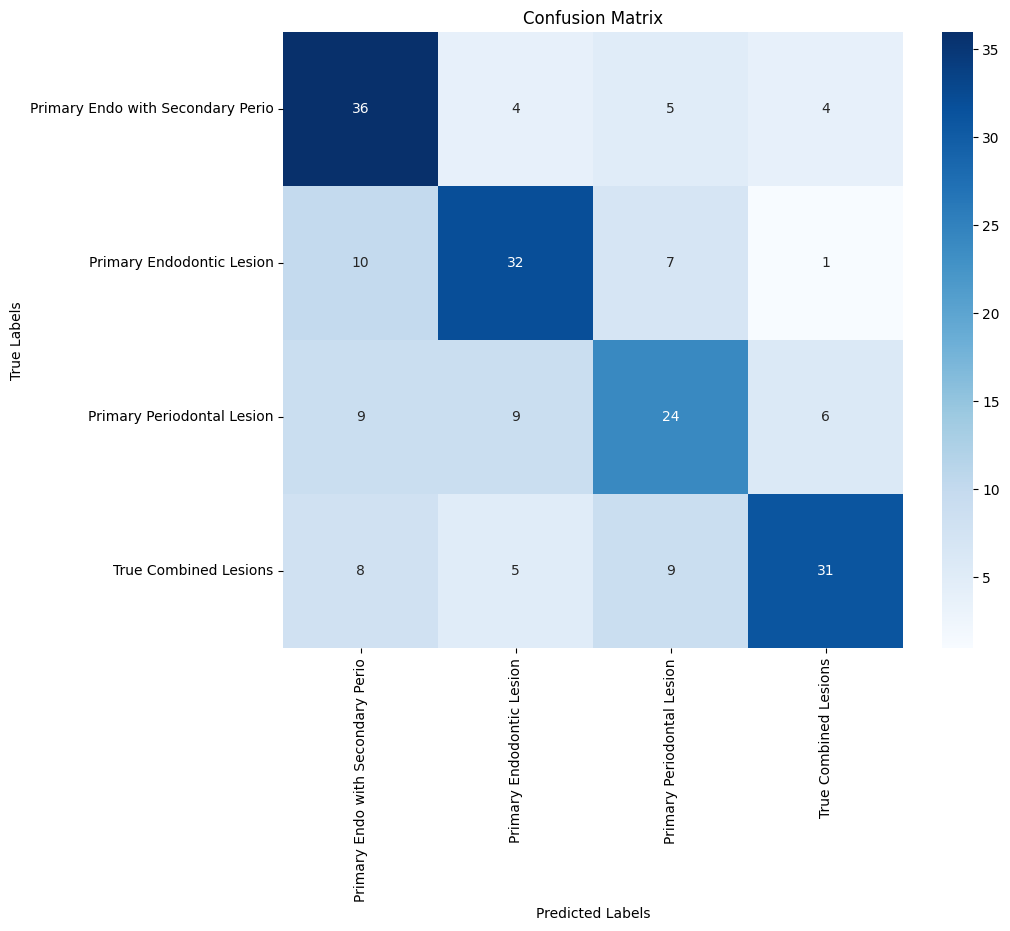

In [ ]:
test_generator.reset()
predictions = model4.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

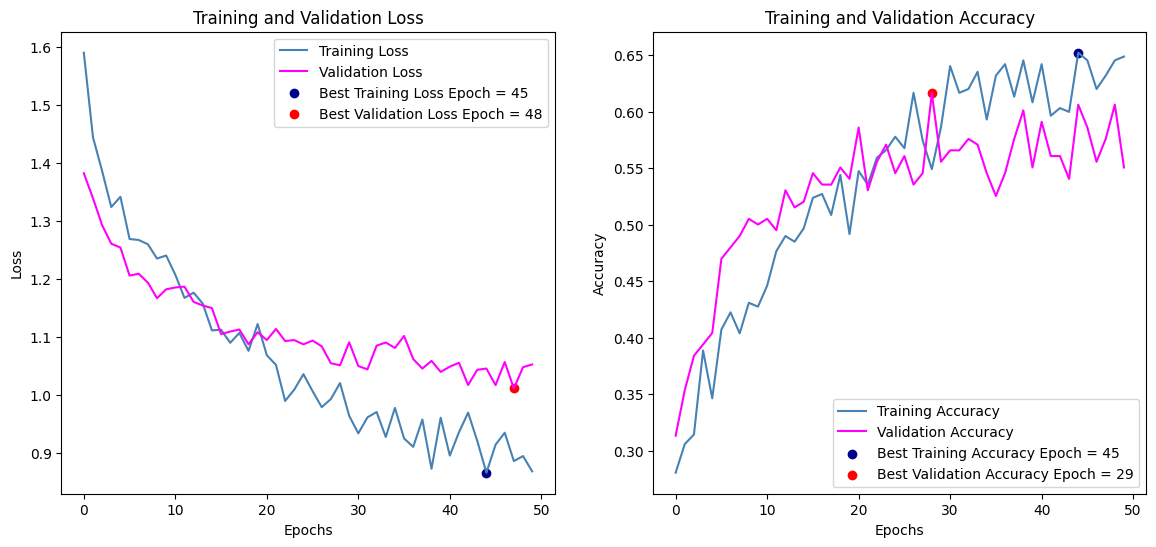

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history4.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history4.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history4.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history4.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history4.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history4.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history4.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history4.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history4.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history4.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history4.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history4.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.62
Recall: 0.61
F1-Score: 0.61
Accuracy: 0.61


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.57
  Recall: 0.73
  F1-Score: 0.64
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.64
  Recall: 0.64
  F1-Score: 0.64
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.53
  Recall: 0.50
  F1-Score: 0.52
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.74
  Recall: 0.58
  F1-Score: 0.65
  Support: 53

Overall Metrics:
Weighted Precision: 0.62
Weighted Recall: 0.61
Weighted F1-Score: 0.61
Accuracy: 0.61

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.571429  0.734694   
1                         Primary Endodontic Lesion   0.640000  0.640000   
2                        Primary Periodontal Lesion   0.533333  0.500000   
3                             True Combined Lesions   0.738095  0.584906   
Weighted Average                            Overall   0.623595  0.615000   



# Hyperparameter 2

In [ ]:
###### from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model5 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model5.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model5.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ ?                      │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 1,054,720 (4.02 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history5 = model5.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.2531 - loss: 1.5826 - val_accuracy: 0.2727 - val_loss: 1.4021 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 822ms/step - accuracy: 0.3031 - loss: 1.4181 - val_accuracy: 0.3182 - val_loss: 1.3634 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 817ms/step - accuracy: 0.3419 - loss: 1.3804 - val_accuracy: 0.3434 - val_loss: 1.3417 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 815ms/step - accuracy: 0.3192 - loss: 1.3819 - val_accuracy: 0.4040 - val_loss: 1.3045 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 857ms/step - accuracy: 0.3912 - loss: 1.2844 - val_accuracy: 0.4343 - val_loss: 1.2895 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 817ms/step - accuracy: 0.3843 - loss: 1.3322 - val_accuracy: 0.4495 - val_loss: 1.2740 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 814ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model5.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 963ms/step - accuracy: 0.6710 - loss: 0.9318
Test Accuracy: 64.50%


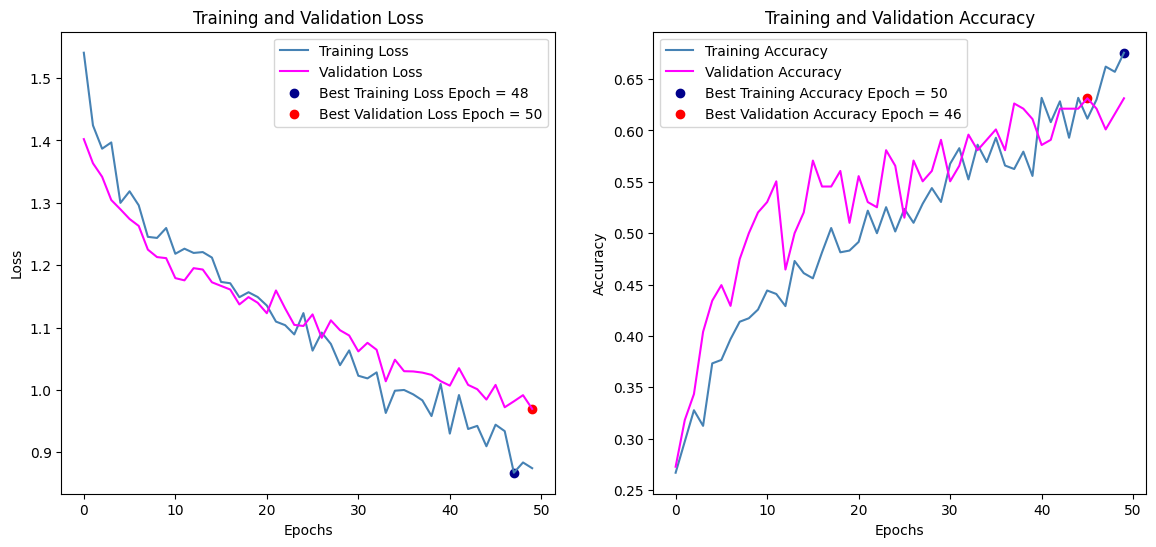

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history5.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history5.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history5.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history5.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history5.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history5.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history5.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history5.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history5.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history5.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history5.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history5.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step 


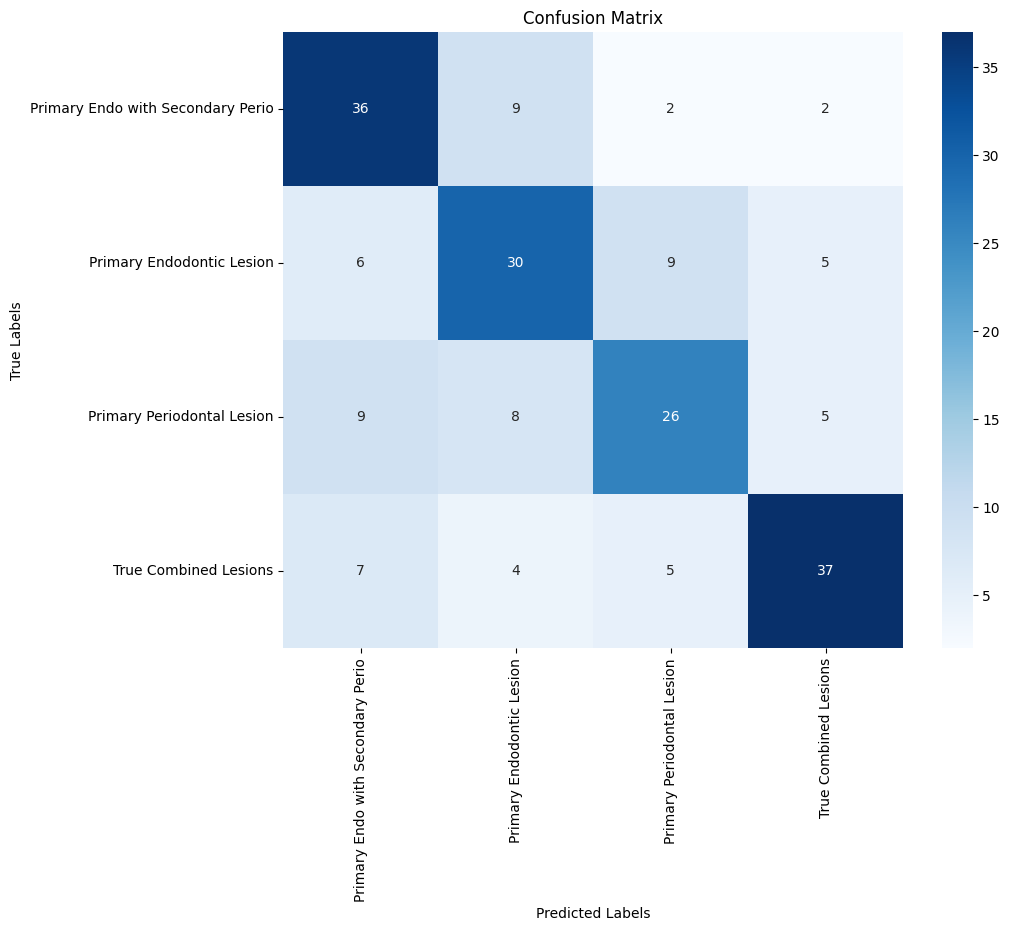

In [ ]:
test_generator.reset()
predictions = model5.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.65
Recall: 0.65
F1-Score: 0.64
Accuracy: 0.65


# Hyperparameter 2_1

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model6 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

# Kompilasi model
model6.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model6.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ ?                      │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 1,054,720 (4.02 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history6 = model6.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.2928 - loss: 1.4565 - val_accuracy: 0.4394 - val_loss: 1.3053 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 804ms/step - accuracy: 0.4439 - loss: 1.2010 - val_accuracy: 0.4596 - val_loss: 1.2317 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 822ms/step - accuracy: 0.5137 - loss: 1.1274 - val_accuracy: 0.4596 - val_loss: 1.2109 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 732ms/step - accuracy: 0.5794 - loss: 1.0260 - val_accuracy: 0.4949 - val_loss: 1.1654 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 808ms/step - accuracy: 0.5676 - loss: 1.0165 - val_accuracy: 0.5253 - val_loss: 1.1564 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 793ms/step - accuracy: 0.6602 - loss: 0.9155 - val_accuracy: 0.5101 - val_loss: 1.1780 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 838ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model6.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 975ms/step - accuracy: 0.7667 - loss: 0.7198
Test Accuracy: 75.00%


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step 


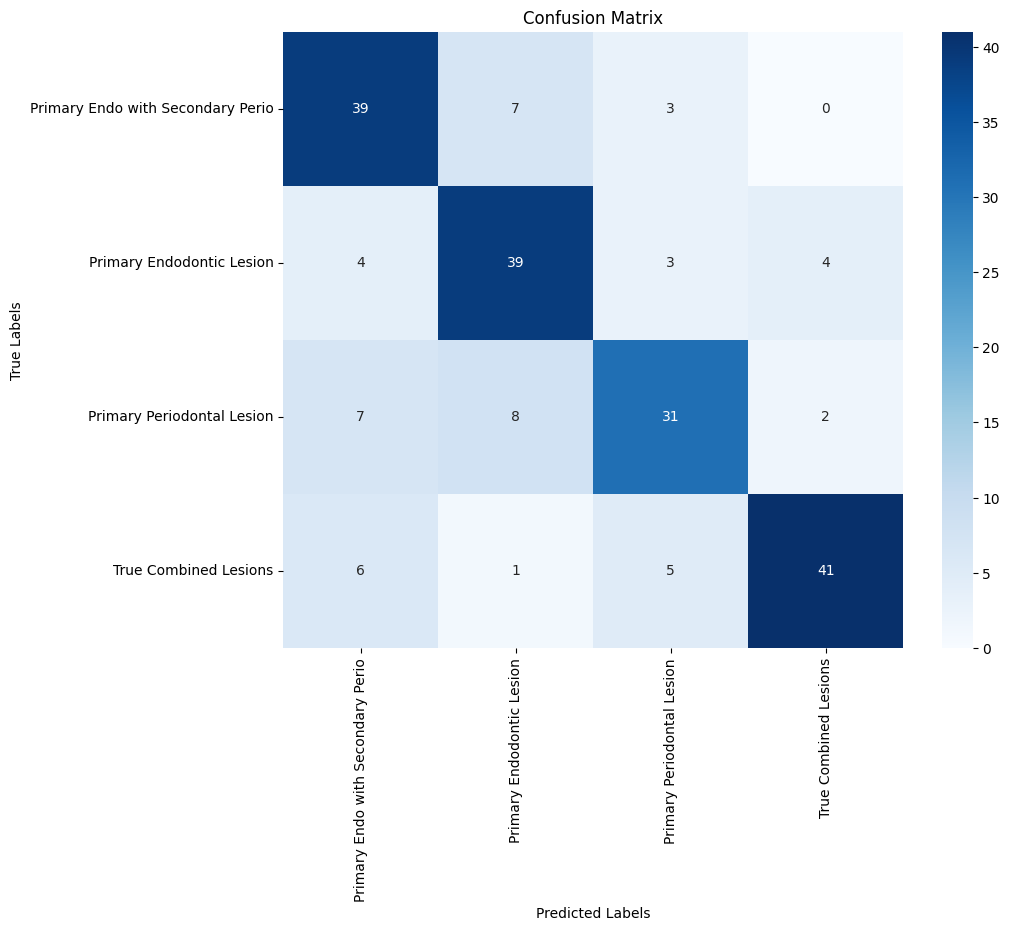

In [ ]:
test_generator.reset()
predictions = model6.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

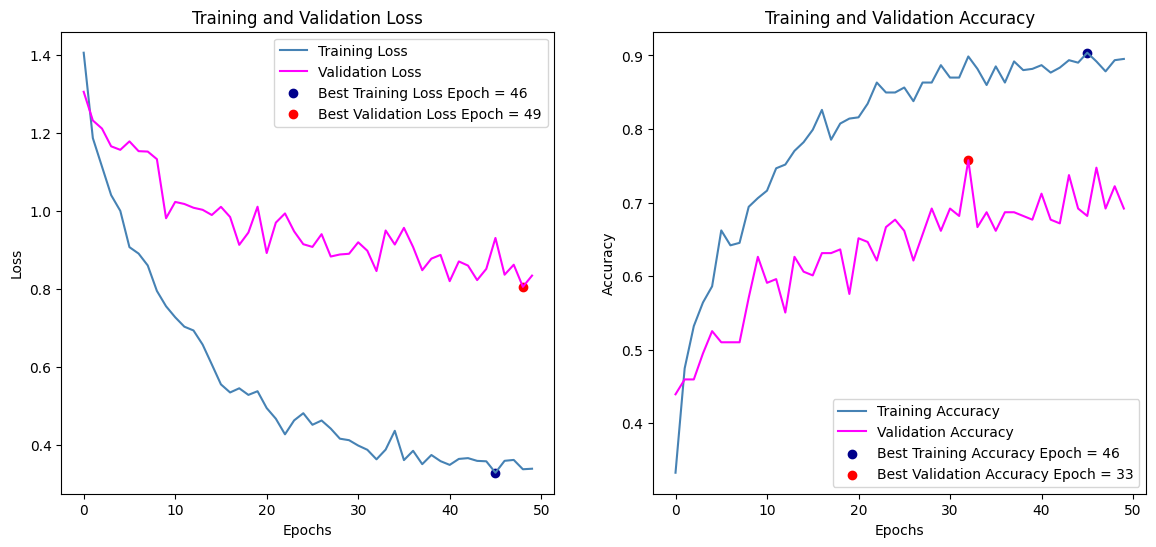

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history6.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history6.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history6.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history6.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history6.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history6.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history6.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history6.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history6.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history6.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history6.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history6.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.76
Recall: 0.75
F1-Score: 0.75
Accuracy: 0.75


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.70
  Recall: 0.80
  F1-Score: 0.74
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.71
  Recall: 0.78
  F1-Score: 0.74
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.74
  Recall: 0.65
  F1-Score: 0.69
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.87
  Recall: 0.77
  F1-Score: 0.82
  Support: 53

Overall Metrics:
Weighted Precision: 0.76
Weighted Recall: 0.75
Weighted F1-Score: 0.75
Accuracy: 0.75

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.696429  0.795918   
1                         Primary Endodontic Lesion   0.709091  0.780000   
2                        Primary Periodontal Lesion   0.738095  0.645833   
3                             True Combined Lesions   0.872340  0.773585   
Weighted Average                            Overall   0.756211  0.750000   



# HYPERPARAMETER 3_1


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model7 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

# Kompilasi model
model7.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model7.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ ?                      │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 1,054,720 (4.02 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history7 = model7.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.2934 - loss: 1.4688 - val_accuracy: 0.2626 - val_loss: 1.3923 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 745ms/step - accuracy: 0.2812 - loss: 1.4216 - val_accuracy: 0.2778 - val_loss: 1.3764 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 817ms/step - accuracy: 0.3017 - loss: 1.3825 - val_accuracy: 0.3687 - val_loss: 1.3540 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 858ms/step - accuracy: 0.4171 - loss: 1.3189 - val_accuracy: 0.3990 - val_loss: 1.3217 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 803ms/step - accuracy: 0.3169 - loss: 1.3275 - val_accuracy: 0.4596 - val_loss: 1.2787 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 858ms/step - accuracy: 0.3976 - loss: 1.2801 - val_accuracy: 0.4242 - val_loss: 1.2578 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 852ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model7.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 929ms/step - accuracy: 0.6748 - loss: 0.9506
Test Accuracy: 67.00%


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step 


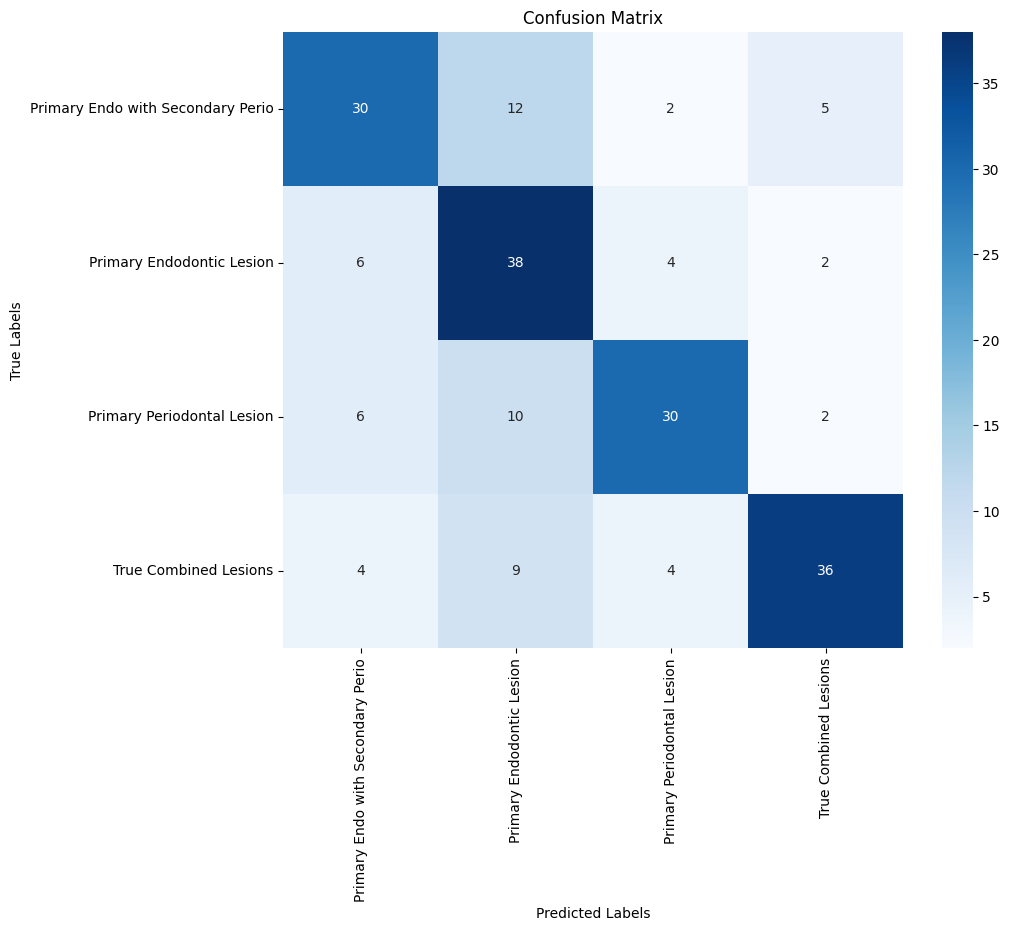

In [ ]:
test_generator.reset()
predictions = model7.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

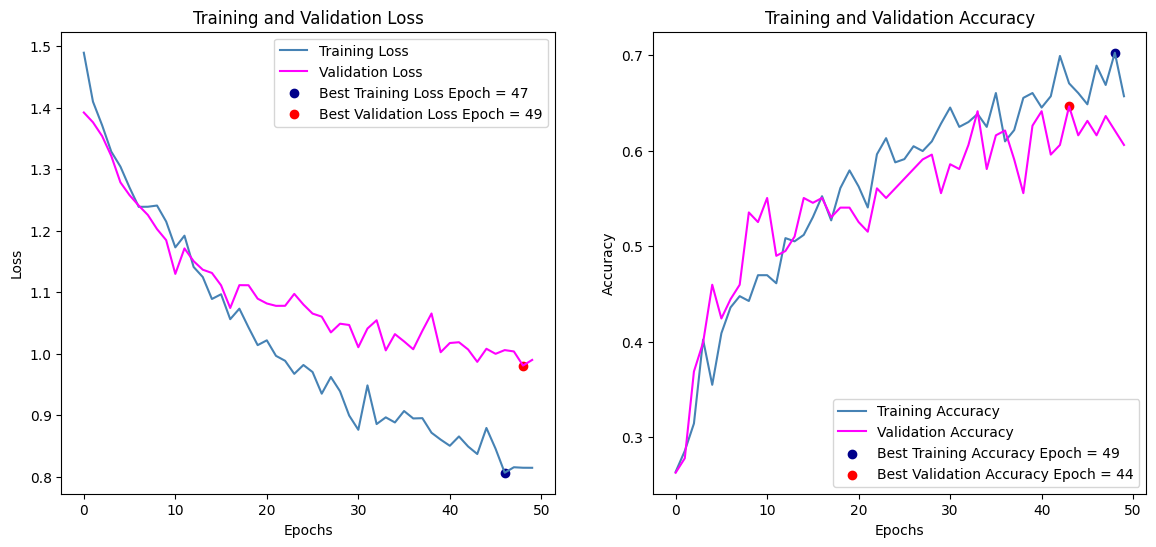

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history7.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history7.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history7.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history7.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history7.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history7.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history7.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history7.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history7.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history7.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history7.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history7.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.69
Recall: 0.67
F1-Score: 0.67
Accuracy: 0.67


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.65
  Recall: 0.61
  F1-Score: 0.63
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.55
  Recall: 0.76
  F1-Score: 0.64
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.75
  Recall: 0.62
  F1-Score: 0.68
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.80
  Recall: 0.68
  F1-Score: 0.73
  Support: 53

Overall Metrics:
Weighted Precision: 0.69
Weighted Recall: 0.67
Weighted F1-Score: 0.67
Accuracy: 0.67

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.652174  0.612245   
1                         Primary Endodontic Lesion   0.550725  0.760000   
2                        Primary Periodontal Lesion   0.750000  0.625000   
3                             True Combined Lesions   0.800000  0.679245   
Weighted Average                            Overall   0.689464  0.670000   



# Hyperparameter 3_2

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model8 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model8.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model8.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ ?                      │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 1,054,720 (4.02 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history8 = model8.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.2309 - loss: 1.7216 - val_accuracy: 0.3939 - val_loss: 1.3468 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 762ms/step - accuracy: 0.2775 - loss: 1.5244 - val_accuracy: 0.3232 - val_loss: 1.3448 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 859ms/step - accuracy: 0.2895 - loss: 1.4927 - val_accuracy: 0.3636 - val_loss: 1.3348 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 862ms/step - accuracy: 0.2385 - loss: 1.5059 - val_accuracy: 0.3990 - val_loss: 1.2994 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 784ms/step - accuracy: 0.2996 - loss: 1.4252 - val_accuracy: 0.3838 - val_loss: 1.3027 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 807ms/step - accuracy: 0.3269 - loss: 1.3748 - val_accuracy: 0.3889 - val_loss: 1.2752 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 736ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model8.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 929ms/step - accuracy: 0.5166 - loss: 1.0844
Test Accuracy: 50.50%


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step 


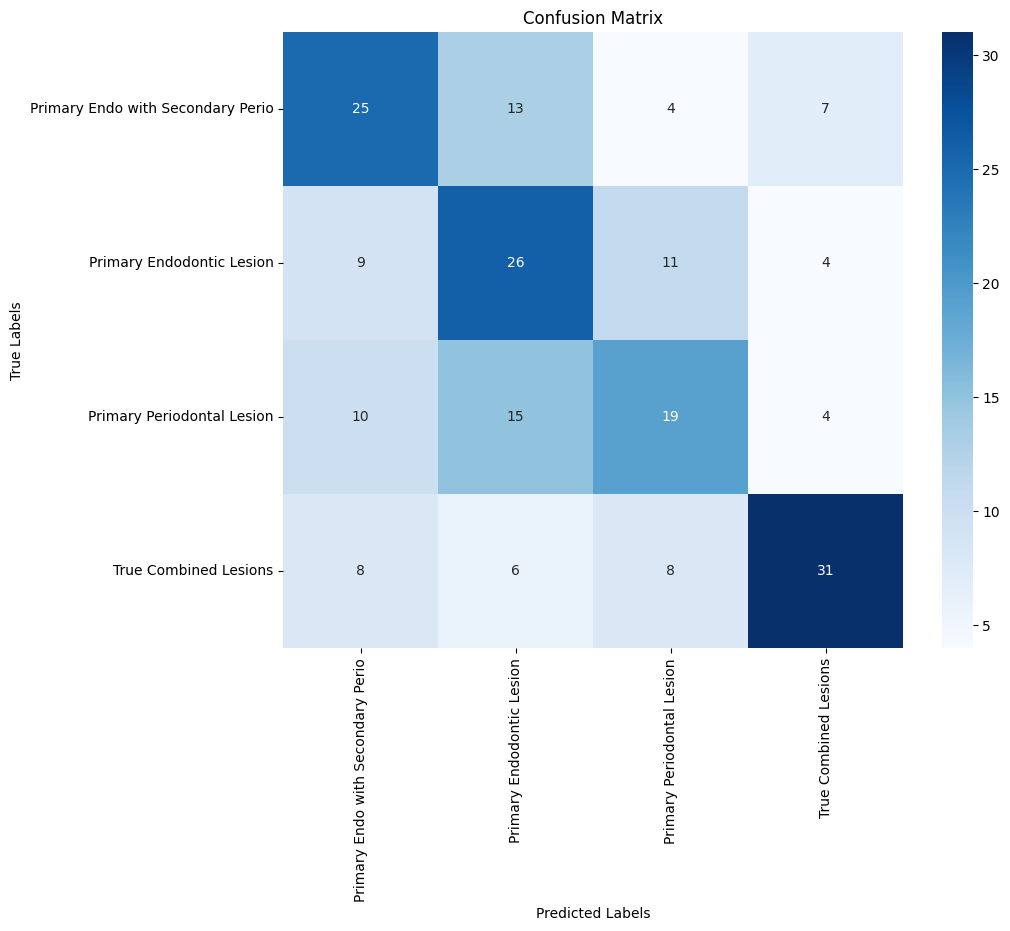

In [ ]:
test_generator.reset()
predictions = model8.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

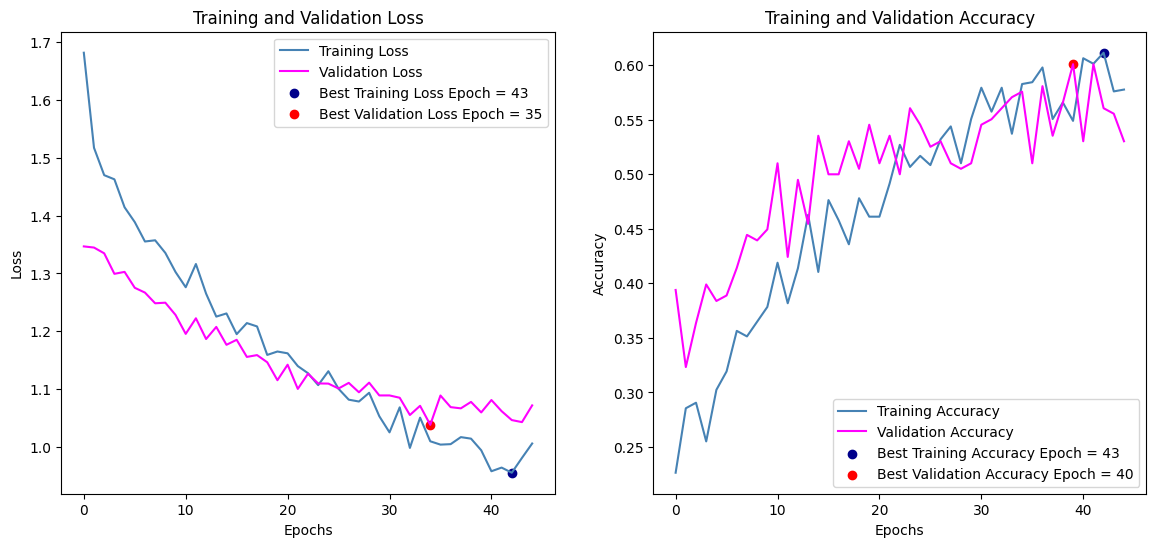

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history8.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history8.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history8.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history8.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history8.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history8.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history8.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history8.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history8.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history8.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history8.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history8.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.51
Recall: 0.51
F1-Score: 0.51
Accuracy: 0.51


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.48
  Recall: 0.51
  F1-Score: 0.50
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.43
  Recall: 0.52
  F1-Score: 0.47
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.45
  Recall: 0.40
  F1-Score: 0.42
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.67
  Recall: 0.58
  F1-Score: 0.63
  Support: 53

Overall Metrics:
Weighted Precision: 0.51
Weighted Recall: 0.51
Weighted F1-Score: 0.51
Accuracy: 0.51

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.480769  0.510204   
1                         Primary Endodontic Lesion   0.433333  0.520000   
2                        Primary Periodontal Lesion   0.452381  0.395833   
3                             True Combined Lesions   0.673913  0.584906   
Weighted Average                            Overall   0.513280  0.505000   



# Hyperparameter 3_3



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model9 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model9.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model9.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ ?                      │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 1,054,720 (4.02 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history9 = model9.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.2551 - loss: 1.5920 - val_accuracy: 0.2374 - val_loss: 1.4502 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 861ms/step - accuracy: 0.2539 - loss: 1.5057 - val_accuracy: 0.3283 - val_loss: 1.3627 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 865ms/step - accuracy: 0.2926 - loss: 1.4256 - val_accuracy: 0.3838 - val_loss: 1.3346 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 829ms/step - accuracy: 0.3073 - loss: 1.4159 - val_accuracy: 0.4040 - val_loss: 1.3056 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 815ms/step - accuracy: 0.2964 - loss: 1.3911 - val_accuracy: 0.4343 - val_loss: 1.3035 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 811ms/step - accuracy: 0.3355 - loss: 1.3467 - val_accuracy: 0.4141 - val_loss: 1.2882 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 794ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model9.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 937ms/step - accuracy: 0.6246 - loss: 1.0116
Test Accuracy: 61.50%


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step 


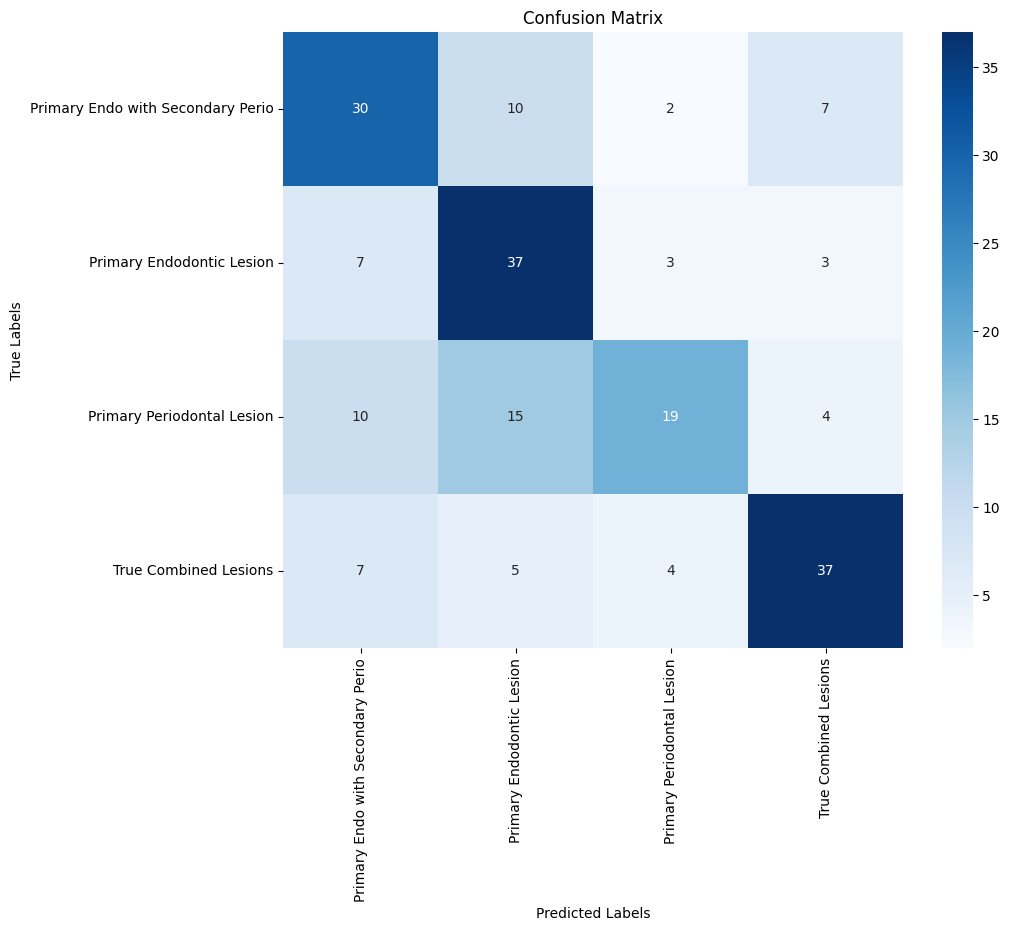

In [ ]:
test_generator.reset()
predictions = model9.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

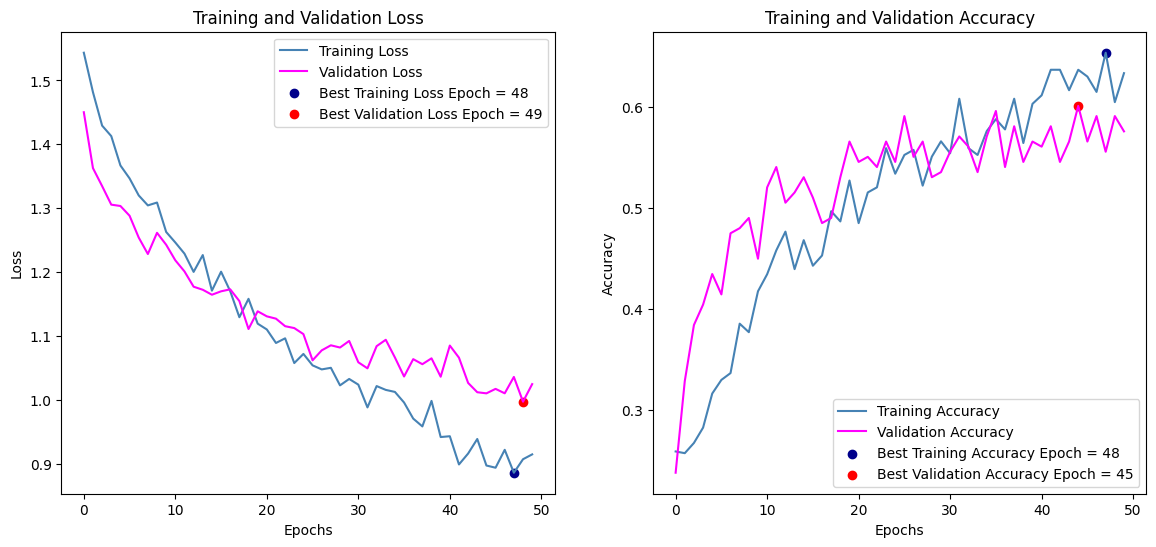

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history9.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history9.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history9.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history9.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history9.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history9.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history9.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history9.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history9.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history9.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history9.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history9.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.63
Recall: 0.61
F1-Score: 0.61
Accuracy: 0.61


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.56
  Recall: 0.61
  F1-Score: 0.58
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.55
  Recall: 0.74
  F1-Score: 0.63
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.68
  Recall: 0.40
  F1-Score: 0.50
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.73
  Recall: 0.70
  F1-Score: 0.71
  Support: 53

Overall Metrics:
Weighted Precision: 0.63
Weighted Recall: 0.61
Weighted F1-Score: 0.61
Accuracy: 0.61

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.555556  0.612245   
1                         Primary Endodontic Lesion   0.552239  0.740000   
2                        Primary Periodontal Lesion   0.678571  0.395833   
3                             True Combined Lesions   0.725490  0.698113   
Weighted Average                            Overall   0.629283  0.615000   



# Validasi tidak pakai Proses augmentasi

In [ ]:
# Generator untuk data train
train_generator1 = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

# Generator untuk data validation
validation_generator1 = validation_datagen.flow_from_directory(
    val_directory,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Generator untuk data test
test_generator1 = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 592 images belonging to 4 classes.
Found 198 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


# Resnet101v2

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model4 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model4.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model4.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ ?                      │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 1,054,720 (4.02 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history4 = model4.fit(
    train_generator1,
    validation_data=validation_generator1,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.2308 - loss: 1.6185 - val_accuracy: 0.2828 - val_loss: 1.4523 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 657ms/step - accuracy: 0.3129 - loss: 1.5025 - val_accuracy: 0.3485 - val_loss: 1.3800 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 617ms/step - accuracy: 0.3066 - loss: 1.4375 - val_accuracy: 0.3636 - val_loss: 1.3290 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 608ms/step - accuracy: 0.3816 - loss: 1.3294 - val_accuracy: 0.4091 - val_loss: 1.2992 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 604ms/step - accuracy: 0.3938 - loss: 1.3222 - val_accuracy: 0.4091 - val_loss: 1.2772 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 620ms/step - accuracy: 0.4160 - loss: 1.2892 - val_accuracy: 0.4394 - val_loss: 1.2567 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 611ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model4.evaluate(test_generator1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 871ms/step - accuracy: 0.6923 - loss: 0.8253
Test Accuracy: 68.00%


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step 


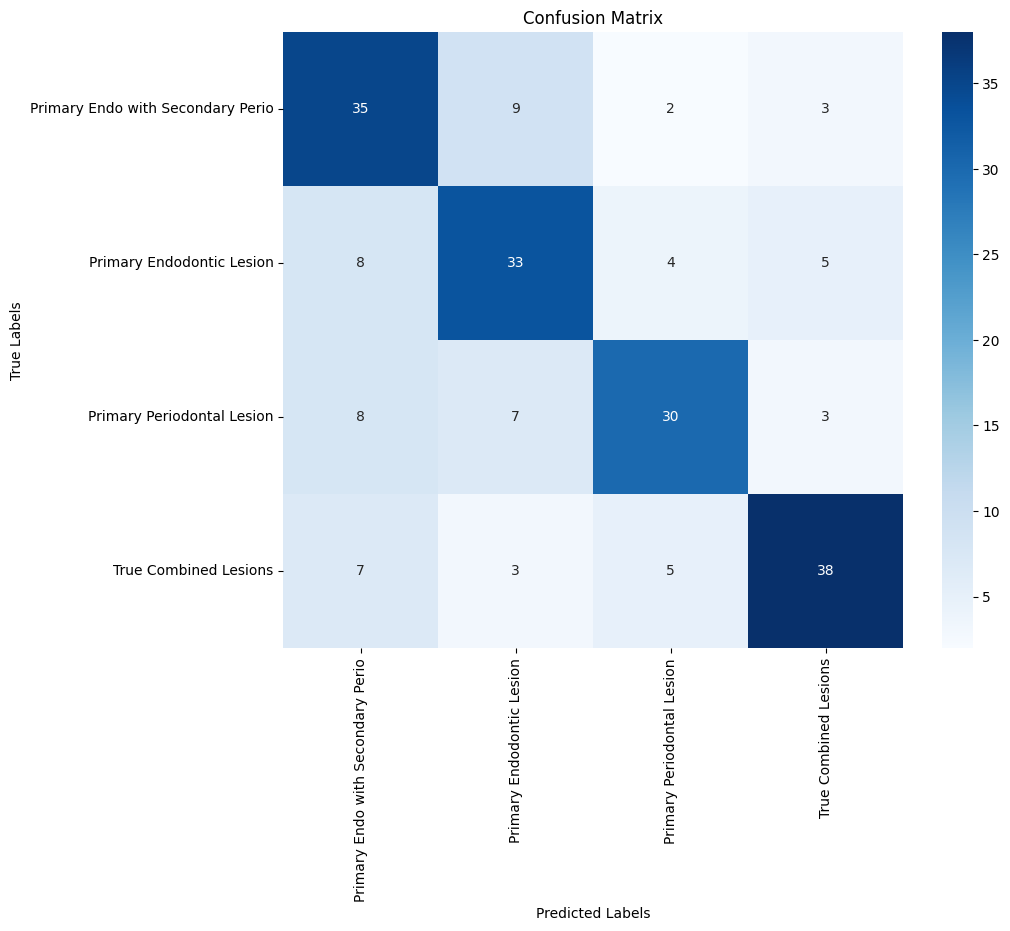

In [ ]:
test_generator1.reset()
predictions = model4.predict(test_generator1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator1.classes
class_labels = list(test_generator1.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

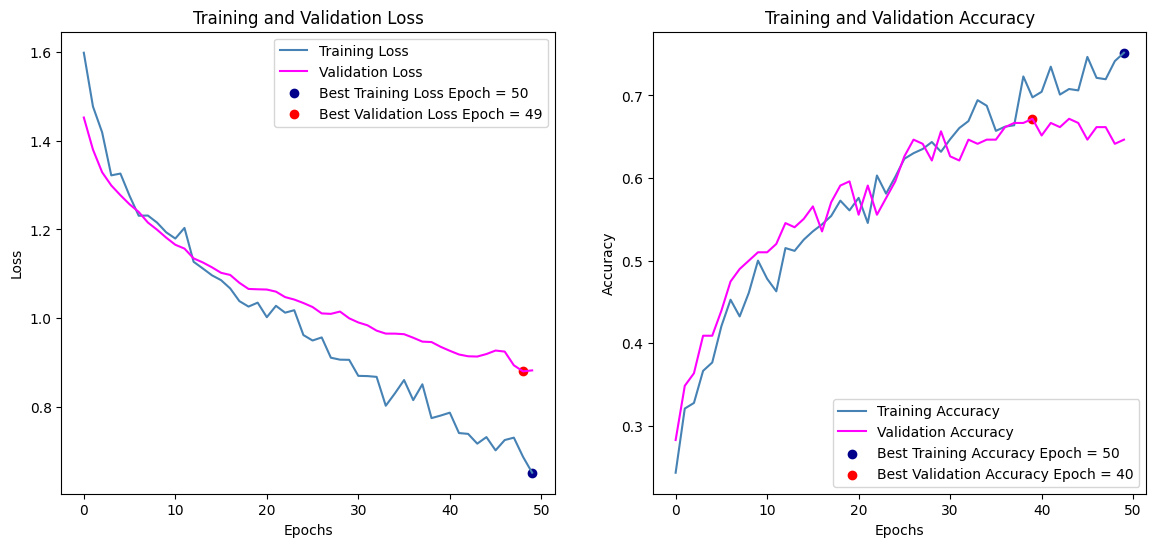

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history4.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history4.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history4.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history4.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history4.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history4.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history4.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history4.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history4.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history4.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history4.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history4.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.69
Recall: 0.68
F1-Score: 0.68
Accuracy: 0.68


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.60
  Recall: 0.71
  F1-Score: 0.65
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.63
  Recall: 0.66
  F1-Score: 0.65
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.73
  Recall: 0.62
  F1-Score: 0.67
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.78
  Recall: 0.72
  F1-Score: 0.75
  Support: 53

Overall Metrics:
Weighted Precision: 0.69
Weighted Recall: 0.68
Weighted F1-Score: 0.68
Accuracy: 0.68

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.603448  0.714286   
1                         Primary Endodontic Lesion   0.634615  0.660000   
2                        Primary Periodontal Lesion   0.731707  0.625000   
3                             True Combined Lesions   0.775510  0.716981   
Weighted Average                            Overall   0.687619  0.680000   



*italicized text*# Hyperparameter 2

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model5 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model5.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model5.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ ?                      │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 1,054,720 (4.02 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
history5 = model5.fit(
    train_generator1,
    validation_data=validation_generator1,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.2772 - loss: 1.4942 - val_accuracy: 0.3283 - val_loss: 1.3739 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 588ms/step - accuracy: 0.3030 - loss: 1.4447 - val_accuracy: 0.3990 - val_loss: 1.3324 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 595ms/step - accuracy: 0.3176 - loss: 1.4004 - val_accuracy: 0.4293 - val_loss: 1.3083 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 594ms/step - accuracy: 0.3460 - loss: 1.3462 - val_accuracy: 0.4343 - val_loss: 1.2783 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 643ms/step - accuracy: 0.4433 - loss: 1.2621 - val_accuracy: 0.4596 - val_loss: 1.2581 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 580ms/step - accuracy: 0.4150 - loss: 1.2298 - val_accuracy: 0.4747 - val_loss: 1.2316 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 504ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model5.evaluate(test_generator1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 928ms/step - accuracy: 0.2417 - loss: 1.3797
Test Accuracy: 28.00%


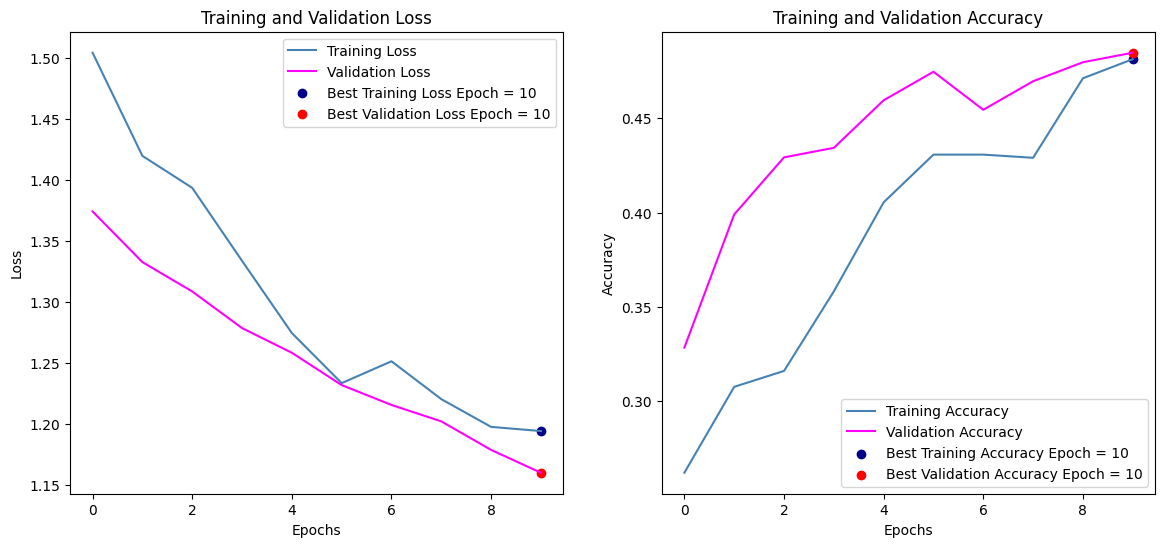

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history5.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history5.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history5.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history5.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history5.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history5.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history5.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history5.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history5.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history5.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history5.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history5.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step 


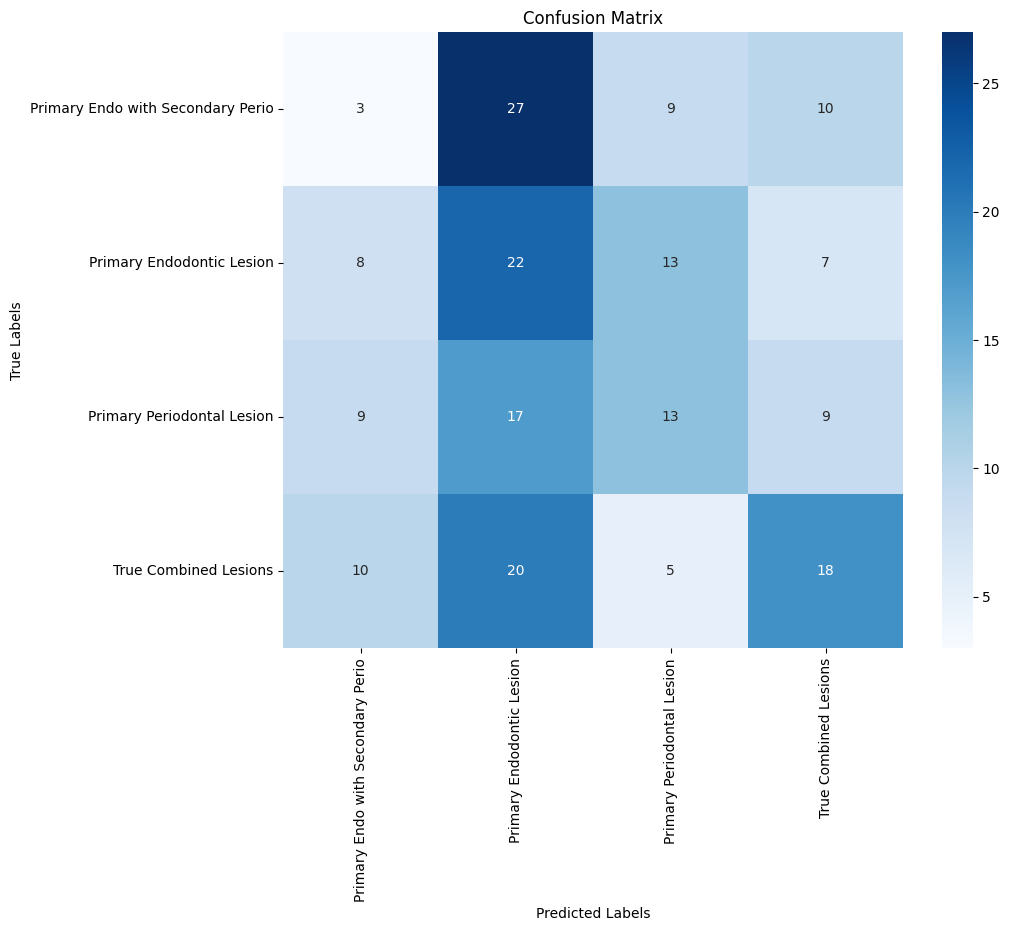

In [ ]:
test_generator1.reset()
predictions = model5.predict(test_generator1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator1.classes
class_labels = list(test_generator1.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.27
Recall: 0.28
F1-Score: 0.27
Accuracy: 0.28


# Hyperparameter 2_1

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model6 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

# Kompilasi model
model6.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model6.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ ?                      │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 1,054,720 (4.02 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history6 = model6.fit(
    train_generator1,
    validation_data=validation_generator1,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.2411 - loss: 1.5324 - val_accuracy: 0.3586 - val_loss: 1.3516 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 603ms/step - accuracy: 0.3953 - loss: 1.2579 - val_accuracy: 0.4444 - val_loss: 1.2469 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 645ms/step - accuracy: 0.4818 - loss: 1.1634 - val_accuracy: 0.4949 - val_loss: 1.1862 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 618ms/step - accuracy: 0.5635 - loss: 1.0479 - val_accuracy: 0.5152 - val_loss: 1.1599 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 607ms/step - accuracy: 0.5541 - loss: 1.0299 - val_accuracy: 0.5253 - val_loss: 1.1373 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 521ms/step - accuracy: 0.6051 - loss: 0.9331 - val_accuracy: 0.5404 - val_loss: 1.1174 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 647ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model6.evaluate(test_generator1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 904ms/step - accuracy: 0.7574 - loss: 0.7482
Test Accuracy: 74.50%


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step 


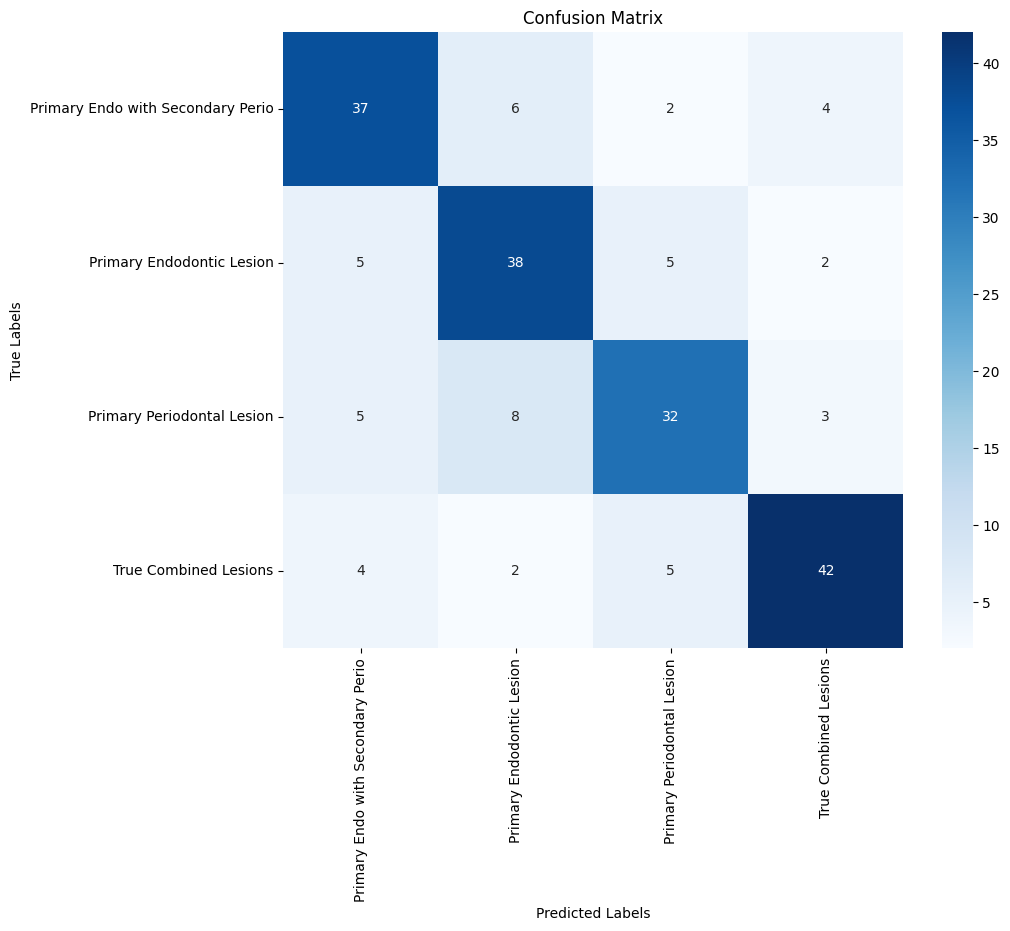

In [ ]:
test_generator1.reset()
predictions = model6.predict(test_generator1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator1.classes
class_labels = list(test_generator1.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

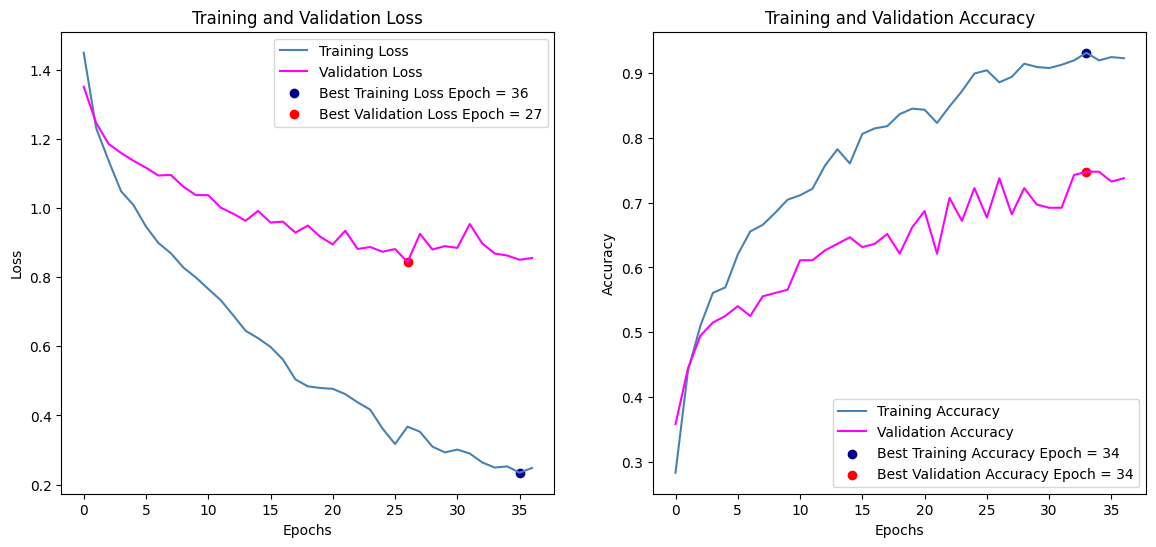

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history6.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history6.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history6.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history6.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history6.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history6.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history6.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history6.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history6.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history6.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history6.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history6.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.75
Recall: 0.74
F1-Score: 0.74
Accuracy: 0.74


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.73
  Recall: 0.76
  F1-Score: 0.74
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.70
  Recall: 0.76
  F1-Score: 0.73
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.73
  Recall: 0.67
  F1-Score: 0.70
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.82
  Recall: 0.79
  F1-Score: 0.81
  Support: 53

Overall Metrics:
Weighted Precision: 0.75
Weighted Recall: 0.74
Weighted F1-Score: 0.74
Accuracy: 0.74

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.725490  0.755102   
1                         Primary Endodontic Lesion   0.703704  0.760000   
2                        Primary Periodontal Lesion   0.727273  0.666667   
3                             True Combined Lesions   0.823529  0.792453   
Weighted Average                            Overall   0.746452  0.745000   



# HYPERPARAMETER 3_1


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model7 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

# Kompilasi model
model7.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model7.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ ?                      │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 1,054,720 (4.02 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history7 = model7.fit(
    train_generator1,
    validation_data=validation_generator1,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.2699 - loss: 1.4626 - val_accuracy: 0.2525 - val_loss: 1.3800 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 548ms/step - accuracy: 0.3094 - loss: 1.3885 - val_accuracy: 0.3182 - val_loss: 1.3308 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 636ms/step - accuracy: 0.2847 - loss: 1.3513 - val_accuracy: 0.3485 - val_loss: 1.2924 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 631ms/step - accuracy: 0.3606 - loss: 1.3466 - val_accuracy: 0.4242 - val_loss: 1.2564 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 624ms/step - accuracy: 0.3497 - loss: 1.3208 - val_accuracy: 0.4444 - val_loss: 1.2311 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 626ms/step - accuracy: 0.3901 - loss: 1.3004 - val_accuracy: 0.4545 - val_loss: 1.2075 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 527ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model7.evaluate(test_generator1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 910ms/step - accuracy: 0.7035 - loss: 0.8197
Test Accuracy: 69.50%


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step 


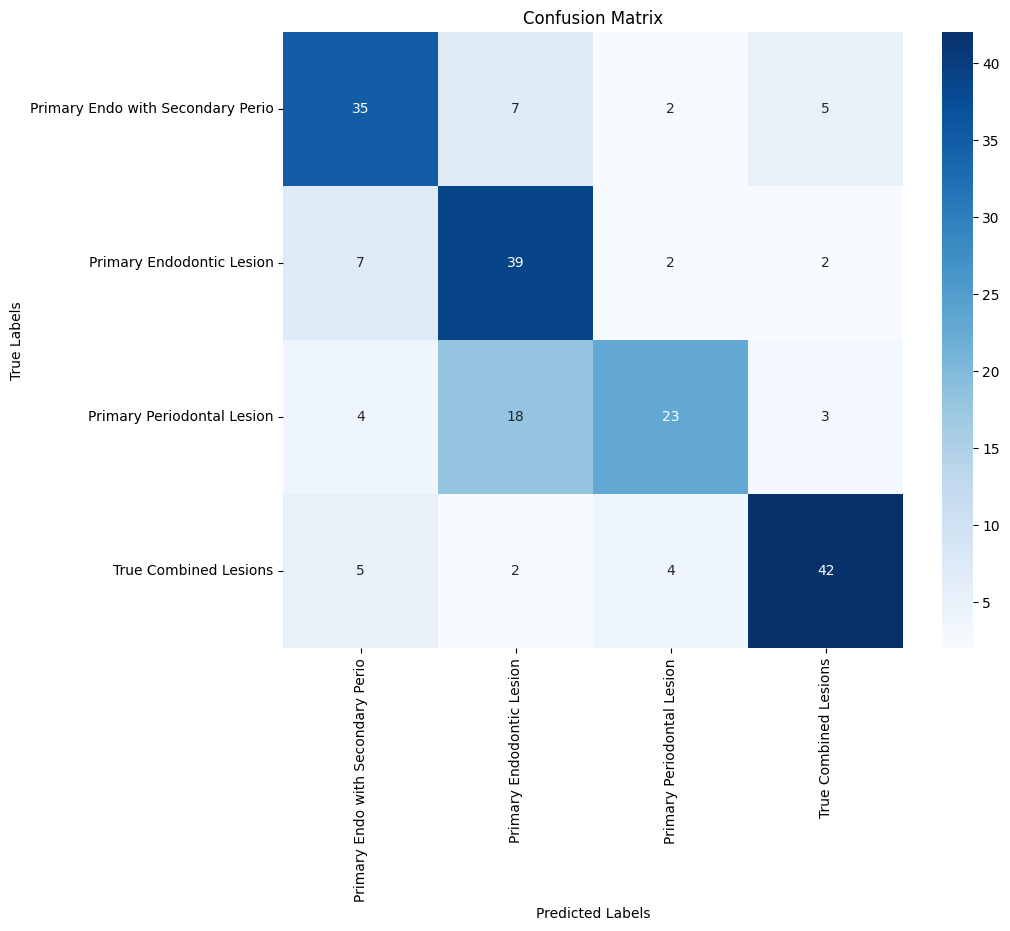

In [ ]:
test_generator1.reset()
predictions = model7.predict(test_generator1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator1.classes
class_labels = list(test_generator1.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

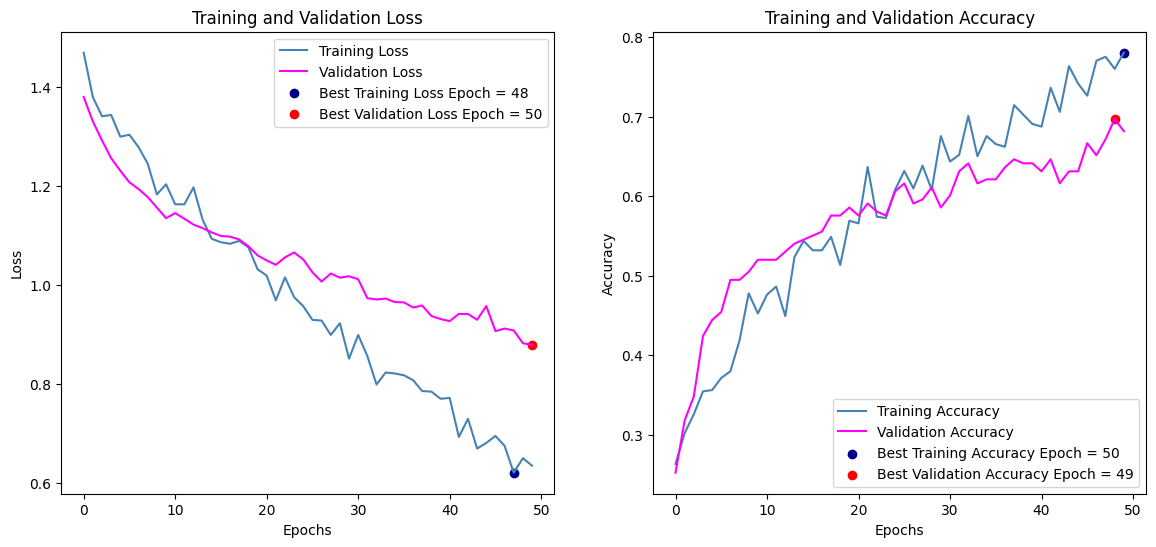

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history7.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history7.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history7.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history7.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history7.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history7.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history7.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history7.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history7.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history7.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history7.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history7.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.71
Recall: 0.69
F1-Score: 0.69
Accuracy: 0.69


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.69
  Recall: 0.71
  F1-Score: 0.70
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.59
  Recall: 0.78
  F1-Score: 0.67
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.74
  Recall: 0.48
  F1-Score: 0.58
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.81
  Recall: 0.79
  F1-Score: 0.80
  Support: 53

Overall Metrics:
Weighted Precision: 0.71
Weighted Recall: 0.69
Weighted F1-Score: 0.69
Accuracy: 0.69

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.686275  0.714286   
1                         Primary Endodontic Lesion   0.590909  0.780000   
2                        Primary Periodontal Lesion   0.741935  0.479167   
3                             True Combined Lesions   0.807692  0.792453   
Weighted Average                            Overall   0.707968  0.695000   



# Hyperparameter 3_2

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model8 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model8.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model8.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ ?                      │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 1,054,720 (4.02 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history8 = model8.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.2765 - loss: 1.7861 - val_accuracy: 0.3535 - val_loss: 1.3643 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 864ms/step - accuracy: 0.2785 - loss: 1.6849 - val_accuracy: 0.3990 - val_loss: 1.3341 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 802ms/step - accuracy: 0.2791 - loss: 1.5568 - val_accuracy: 0.3485 - val_loss: 1.3390 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 729ms/step - accuracy: 0.2870 - loss: 1.4604 - val_accuracy: 0.3687 - val_loss: 1.3082 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 812ms/step - accuracy: 0.3244 - loss: 1.4118 - val_accuracy: 0.4192 - val_loss: 1.2971 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 724ms/step - accuracy: 0.3225 - loss: 1.3934 - val_accuracy: 0.4242 - val_loss: 1.2875 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 834ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model8.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 867ms/step - accuracy: 0.5893 - loss: 1.0347
Test Accuracy: 55.00%


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step 


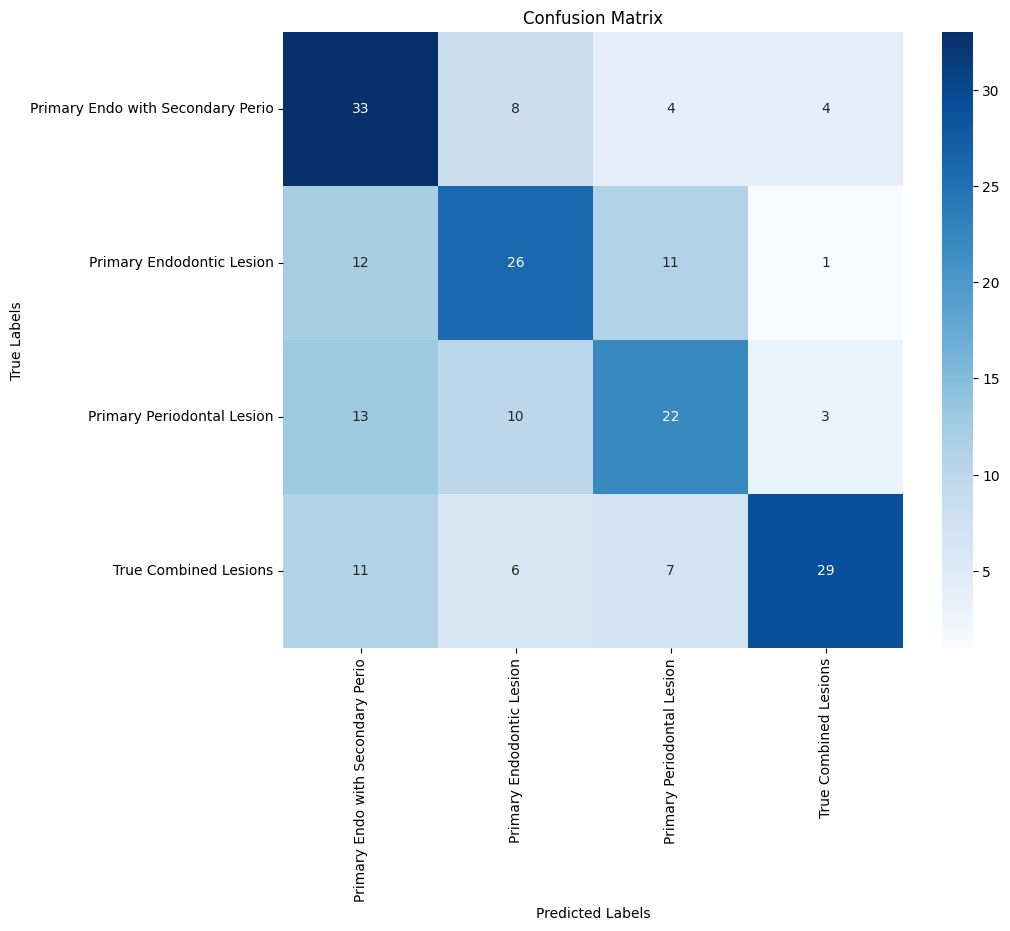

In [ ]:
test_generator.reset()
predictions = model8.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

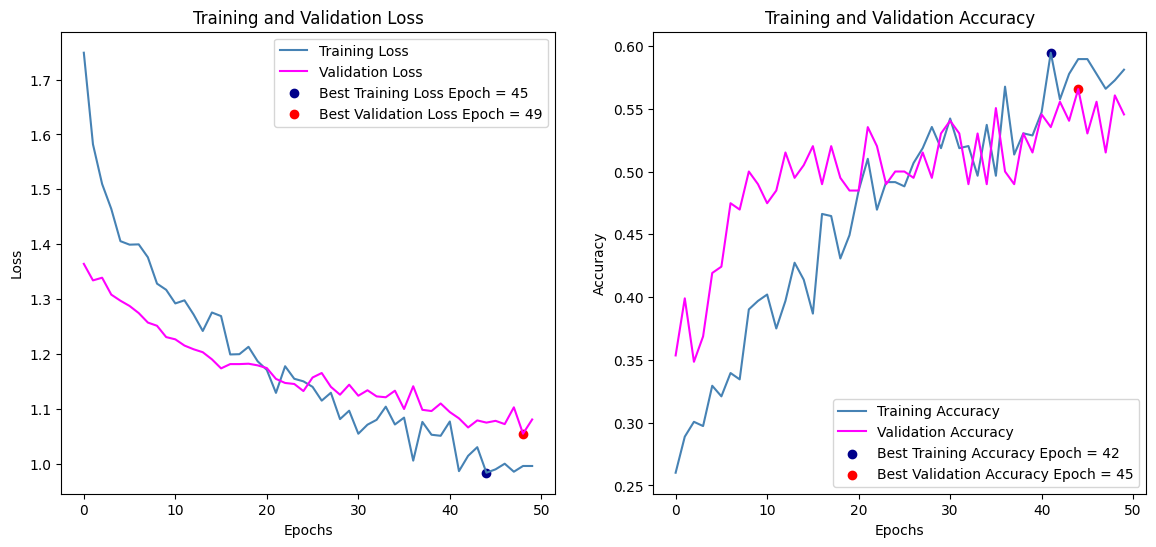

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history8.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history8.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history8.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history8.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history8.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history8.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history8.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history8.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history8.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history8.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history8.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history8.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.57
Recall: 0.55
F1-Score: 0.55
Accuracy: 0.55


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.48
  Recall: 0.67
  F1-Score: 0.56
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.52
  Recall: 0.52
  F1-Score: 0.52
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.50
  Recall: 0.46
  F1-Score: 0.48
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.78
  Recall: 0.55
  F1-Score: 0.64
  Support: 53

Overall Metrics:
Weighted Precision: 0.57
Weighted Recall: 0.55
Weighted F1-Score: 0.55
Accuracy: 0.55

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.478261  0.673469   
1                         Primary Endodontic Lesion   0.520000  0.520000   
2                        Primary Periodontal Lesion   0.500000  0.458333   
3                             True Combined Lesions   0.783784  0.547170   
Weighted Average                            Overall   0.574877  0.550000   



# Hyperparameter 3_3



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model9 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model9.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model9.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ ?                      │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 1,054,720 (4.02 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history9 = model9.fit(
    train_generator1,
    validation_data=validation_generator1,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.2617 - loss: 1.6150 - val_accuracy: 0.3687 - val_loss: 1.3526 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 616ms/step - accuracy: 0.3102 - loss: 1.4284 - val_accuracy: 0.3990 - val_loss: 1.3188 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 620ms/step - accuracy: 0.3070 - loss: 1.4222 - val_accuracy: 0.4192 - val_loss: 1.2994 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 609ms/step - accuracy: 0.3490 - loss: 1.3219 - val_accuracy: 0.4646 - val_loss: 1.2753 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 616ms/step - accuracy: 0.3742 - loss: 1.3260 - val_accuracy: 0.4444 - val_loss: 1.2551 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 605ms/step - accuracy: 0.3622 - loss: 1.3180 - val_accuracy: 0.4697 - val_loss: 1.2457 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 612ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model9.evaluate(test_generator1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 864ms/step - accuracy: 0.7016 - loss: 0.8557
Test Accuracy: 68.50%


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step 


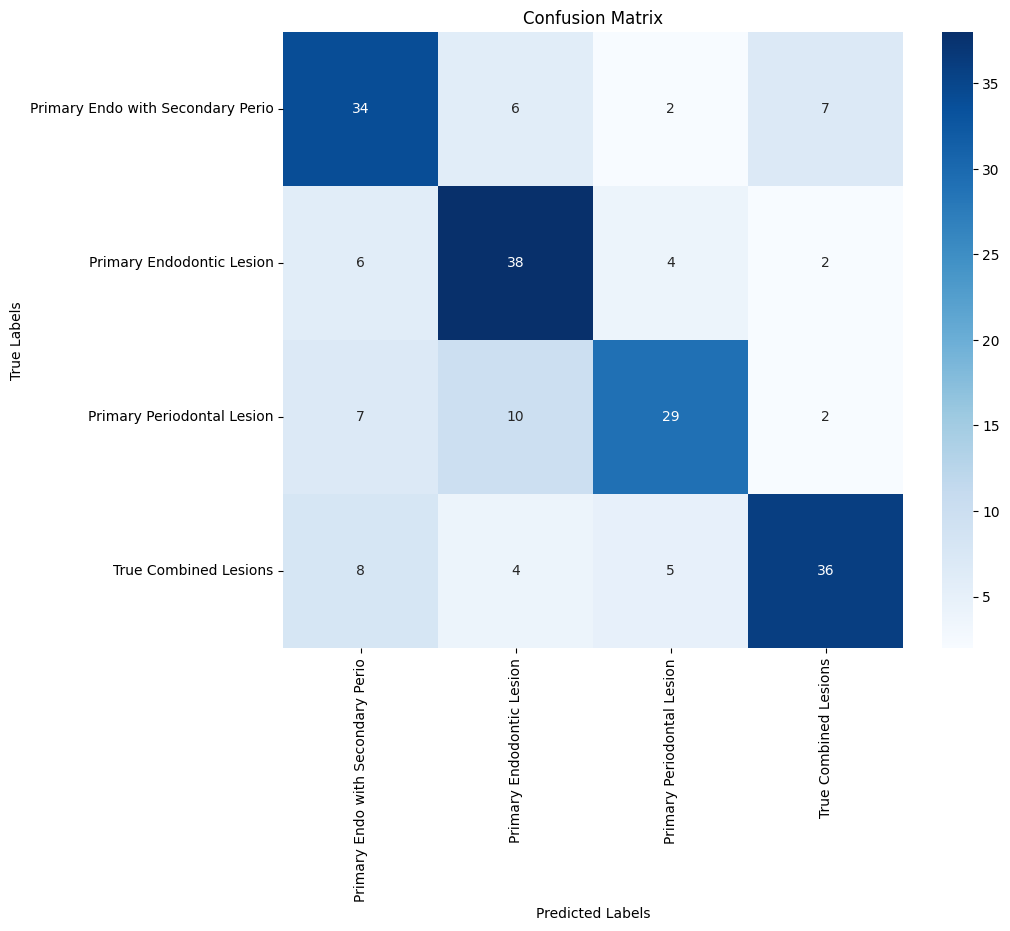

In [ ]:
test_generator1.reset()
predictions = model9.predict(test_generator1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator1.classes
class_labels = list(test_generator1.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

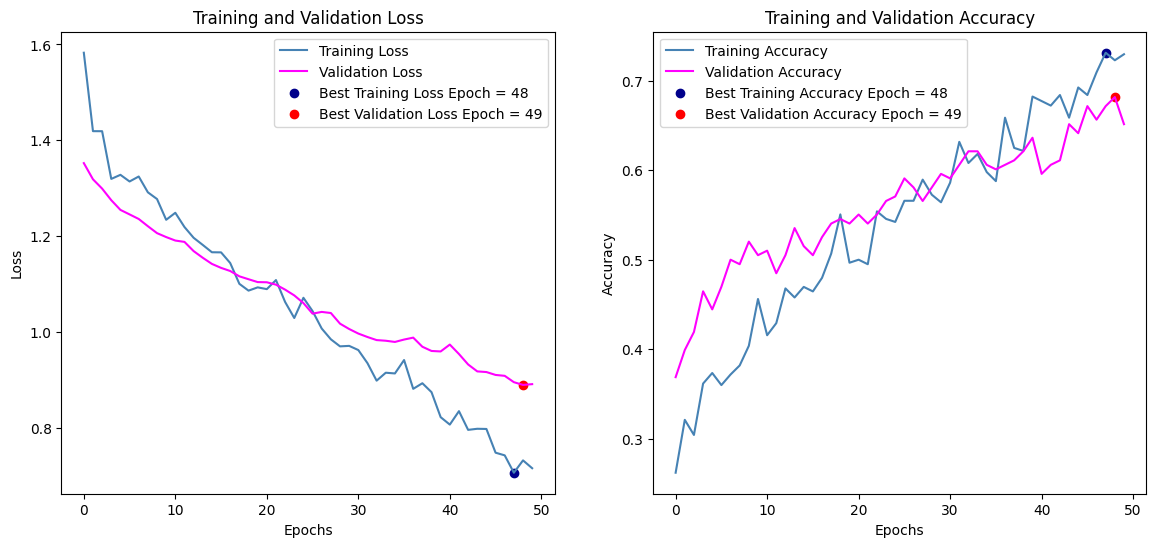

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history9.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history9.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history9.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history9.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history9.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history9.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history9.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history9.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history9.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history9.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history9.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history9.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.69
Recall: 0.69
F1-Score: 0.69
Accuracy: 0.69


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.62
  Recall: 0.69
  F1-Score: 0.65
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.66
  Recall: 0.76
  F1-Score: 0.70
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.72
  Recall: 0.60
  F1-Score: 0.66
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.77
  Recall: 0.68
  F1-Score: 0.72
  Support: 53

Overall Metrics:
Weighted Precision: 0.69
Weighted Recall: 0.69
Weighted F1-Score: 0.69
Accuracy: 0.69

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.618182  0.693878   
1                         Primary Endodontic Lesion   0.655172  0.760000   
2                        Primary Periodontal Lesion   0.725000  0.604167   
3                             True Combined Lesions   0.765957  0.679245   
Weighted Average                            Overall   0.692226  0.685000   



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50V2 (alternatively, ResNet101V2 or ResNet152V2)
base_model = resnet_v2.ResNet101V2(
    weights='imagenet',          # Pretrained weights
    include_top=False,           # Exclude fully connected layers
    input_shape=(224, 224, 3)    # Input image size
)

# Freeze all layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Membangun model baru di atas base model VGG16
model8 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Kompilasi model
model8.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model8.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ ?                      │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_17     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 1,054,720 (4.02 MB)

 Non-trainable params: 41,571,840 (158.58 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]


In [ ]:
history8 = model8.fit(
    train_generator1,
    validation_data=validation_generator1,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.2707 - loss: 1.6211 - val_accuracy: 0.3030 - val_loss: 1.3786 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 538ms/step - accuracy: 0.2958 - loss: 1.5663 - val_accuracy: 0.3687 - val_loss: 1.3411 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 539ms/step - accuracy: 0.2593 - loss: 1.5501 - val_accuracy: 0.4040 - val_loss: 1.3179 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 610ms/step - accuracy: 0.2398 - loss: 1.5118 - val_accuracy: 0.4444 - val_loss: 1.2968 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 609ms/step - accuracy: 0.2670 - loss: 1.4767 - val_accuracy: 0.4545 - val_loss: 1.2910 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 615ms/step - accuracy: 0.3071 - loss: 1.3921 - val_accuracy: 0.4495 - val_loss: 1.2861 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 607ms/step - accura

In [ ]:
# Evaluasi Model
test_loss, test_accuracy = model8.evaluate(test_generator1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 883ms/step - accuracy: 0.6371 - loss: 0.9578
Test Accuracy: 62.00%


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step 


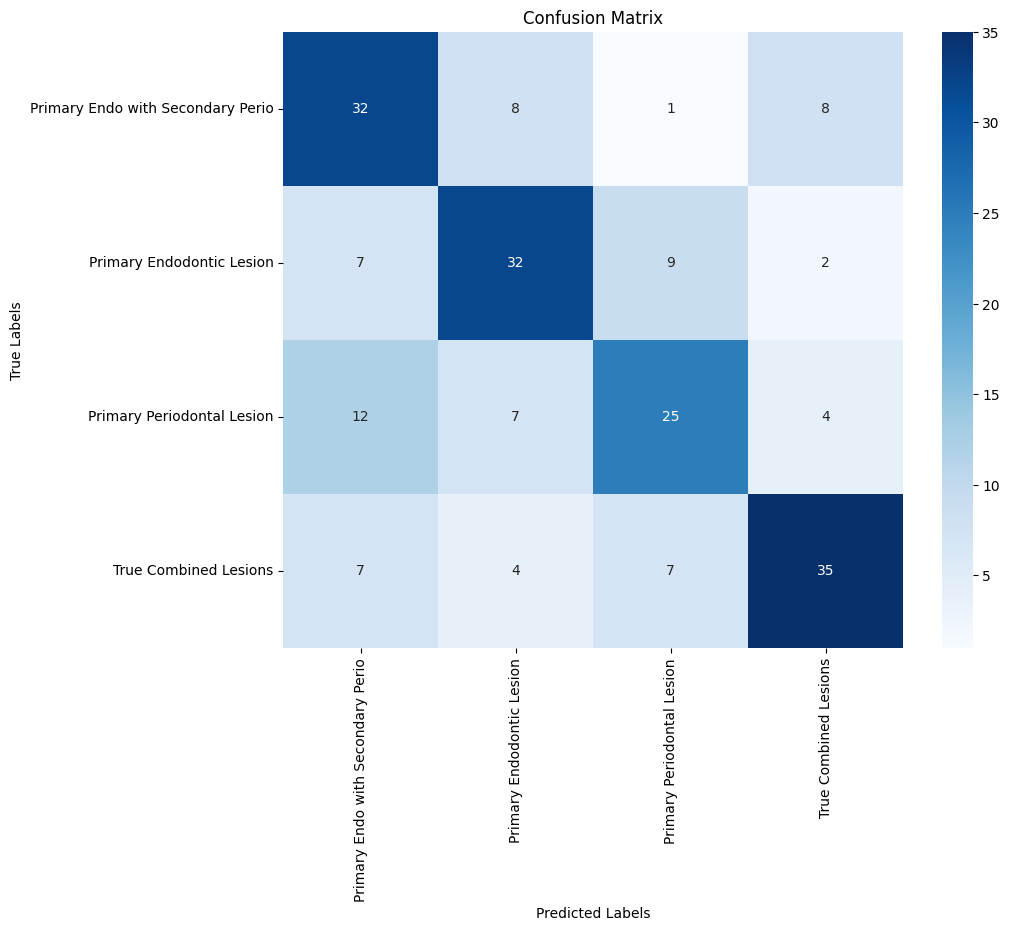

In [ ]:
test_generator1.reset()
predictions = model8.predict(test_generator1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator1.classes
class_labels = list(test_generator1.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

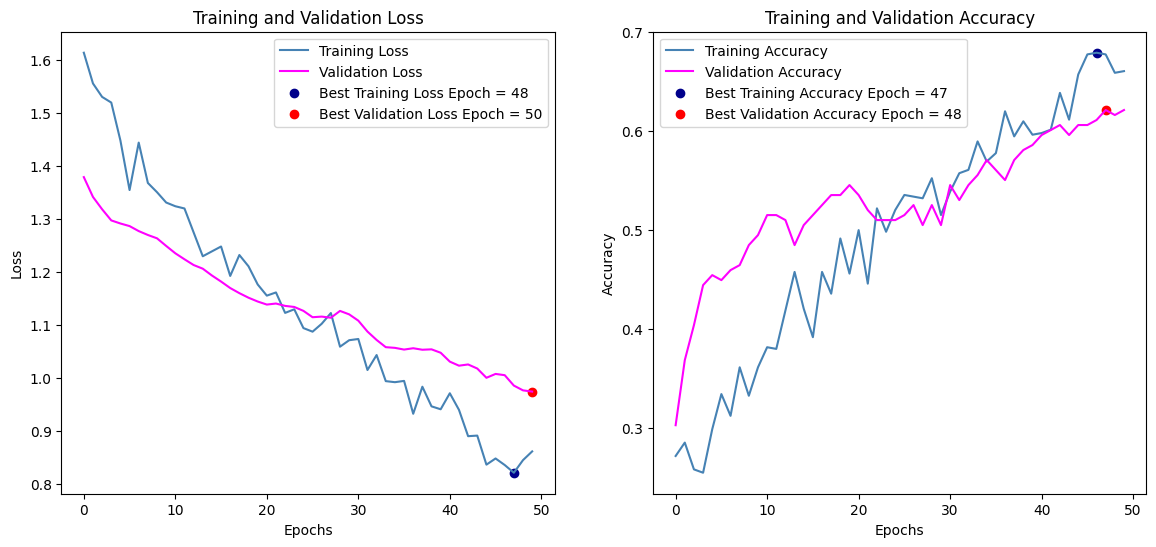

In [ ]:
# Mencari epoch dengan nilai terbaik
best_train_loss_epoch = np.argmin(history8.history['loss'])  # Epoch dengan loss training terbaik
best_val_loss_epoch = np.argmin(history8.history['val_loss'])  # Epoch dengan loss validasi terbaik
best_train_acc_epoch = np.argmax(history8.history['accuracy'])  # Epoch dengan akurasi training terbaik
best_val_acc_epoch = np.argmax(history8.history['val_accuracy'])  # Epoch dengan akurasi validasi terbaik

# Plot loss dan akurasi pada dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Training dan Validation Loss
ax1.plot(history8.history['loss'], label='Training Loss', color='steelblue')  # Grafik loss training
ax1.plot(history8.history['val_loss'], label='Validation Loss', color='magenta')  # Grafik loss validasi

# Titik pada epoch dengan Loss terbaik
ax1.scatter(best_train_loss_epoch, history8.history['loss'][best_train_loss_epoch],
            label=f'Best Training Loss Epoch = {best_train_loss_epoch + 1}', color='darkblue')  # Titik terbaik training
ax1.scatter(best_val_loss_epoch, history8.history['val_loss'][best_val_loss_epoch],
            label=f'Best Validation Loss Epoch = {best_val_loss_epoch + 1}', color='red')  # Titik terbaik validasi

ax1.set_title('Training and Validation Loss')  # Judul subplot
ax1.set_xlabel('Epochs')  # Label sumbu X
ax1.set_ylabel('Loss')  # Label sumbu Y
ax1.legend()  # Menampilkan legenda

# Subplot 2: Training dan Validation Accuracy
ax2.plot(history8.history['accuracy'], label='Training Accuracy', color='steelblue')  # Grafik akurasi training
ax2.plot(history8.history['val_accuracy'], label='Validation Accuracy', color='magenta')  # Grafik akurasi validasi

# Titik pada epoch dengan Accuracy terbaik
ax2.scatter(best_train_acc_epoch, history8.history['accuracy'][best_train_acc_epoch],
            label=f'Best Training Accuracy Epoch = {best_train_acc_epoch + 1}', color='darkblue')  # Titik terbaik training
ax2.scatter(best_val_acc_epoch, history8.history['val_accuracy'][best_val_acc_epoch],
            label=f'Best Validation Accuracy Epoch = {best_val_acc_epoch + 1}', color='red')  # Titik terbaik validasi

ax2.set_title('Training and Validation Accuracy')  # Judul subplot
ax2.set_xlabel('Epochs')  # Label sumbu X
ax2.set_ylabel('Accuracy')  # Label sumbu Y
ax2.legend()  # Menampilkan legenda

# Tampilkan grafik
plt.show()

In [ ]:
# Menampilkan precision, recall, f1-score, dan accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

Precision: 0.62
Recall: 0.62
F1-Score: 0.62
Accuracy: 0.62


In [ ]:
# Menghitung precision, recall, f1-score, dan accuracy
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
overall_accuracy = accuracy_score(true_classes, predicted_classes)

# Menampilkan hasil per kelas
print("Per-Class Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Menampilkan hasil rata-rata tertimbang dan akurasi
print("Overall Metrics:")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-Score: {weighted_f1:.2f}")
print(f"Accuracy: {overall_accuracy:.2f}")

# Menampilkan hasil dalam bentuk tabel menggunakan pandas (opsional)
import pandas as pd

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

metrics_df.loc['Weighted Average'] = ['Overall', weighted_precision, weighted_recall, weighted_f1, sum(support)]

print("\nMetrics Table:")
print(metrics_df)


Per-Class Metrics:
Class 'Primary Endo with Secondary Perio':
  Precision: 0.55
  Recall: 0.65
  F1-Score: 0.60
  Support: 49

Class 'Primary Endodontic Lesion':
  Precision: 0.63
  Recall: 0.64
  F1-Score: 0.63
  Support: 50

Class 'Primary Periodontal Lesion':
  Precision: 0.60
  Recall: 0.52
  F1-Score: 0.56
  Support: 48

Class 'True Combined Lesions':
  Precision: 0.71
  Recall: 0.66
  F1-Score: 0.69
  Support: 53

Overall Metrics:
Weighted Precision: 0.62
Weighted Recall: 0.62
Weighted F1-Score: 0.62
Accuracy: 0.62

Metrics Table:
                                              Class  Precision    Recall  \
0                 Primary Endo with Secondary Perio   0.551724  0.653061   
1                         Primary Endodontic Lesion   0.627451  0.640000   
2                        Primary Periodontal Lesion   0.595238  0.520833   
3                             True Combined Lesions   0.714286  0.660377   
Weighted Average                            Overall   0.624178  0.620000   

